In [1]:
import numpy as np
import matplotlib.pyplot as plt
from solve_consumption_saving import *
from copy import deepcopy
from estimation import *

%load_ext autoreload
%autoreload 2

# %pip install EconModel
from Model import ReferenceDependenceClass
model = ReferenceDependenceClass()
model.par.full_sample_estimation = True
model.allocate()
model_new = deepcopy(model)
model.par.model = 'ConSav'
model_new.par.model = 'ConSav'


# **Estimating using the full sample** #
(using hazard rates from both before and after the reform)

# Model with reference dependence

In [2]:
model.par.eta = 1  # Reference dependence
model.par.types = 1  # No heterogeneity
model.par.euler = True
model.allocate()

est_par = ['delta', 'gamma', 'lambdaa', 'N', 'cost1', 'L'] # Parameters to estimate
theta0 = [0.95, 0.4, 2.0, 15, 100.0, -0.5]  # Initial guesses
bounds = [(0, 1), (0.0, 10.0), (0.0, 10.0), (0,50), (0.0,500), (-0.9,0.0)] # Bounds for the parameters

# est = method_simulated_moments(model, est_par,theta0,bounds,weight=False)

model.par.noOfParams = len(est_par)
model.par.noSearchInits = 1

np.random.seed(180615)
for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(model.par.lb_delta, model.par.ub_delta),
              np.random.uniform(model.par.lb_gamma,model.par.ub_gamma),
              np.random.uniform(model.par.lb_lambdaa,model.par.ub_lambdaa),
              np.random.uniform(model.par.lb_N,model.par.ub_N),
              np.random.uniform(model.par.lb_c,model.par.ub_c),
              np.random.uniform(model.par.lb_L,model.par.ub_L)]

    est_best = np.inf
    try:
        # Perform the method of simulated moments
        est = method_simulated_moments(model, est_par, theta0, bounds, weight=False)

        # Check if the current estimate is better than the best estimate
        if est.fun < est_best:
            est_best = est.fun
            par = est.x
            nit = est.nit

    except Exception as e:
        # Print the exception message and continue with the next iteration
        print(f"Iteration {i} failed with error: {e}")
        continue



print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, est.x):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est.fun:.4f}')
print(f'Number of iterations:    {est.nit}')

d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\solve_consumption_saving.py:90: RuntimeWarning: divide by zero encountered in divide
  par.V_e[t, n, :] = utility(par, sol.c_e[t, n, :], par.r_e_m[t, t+n])/ (1 - par.delta)
d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\solve_consumption_saving.py:90: RuntimeWarning: invalid value encountered in divide
  par.V_e[t, n, :] = utility(par, sol.c_e[t, n, :], par.r_e_m[t, t+n])/ (1 - par.delta)
d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\Funcs.py:26: RuntimeWarning: divide by zero encountered in divide
  mu = np.where(c >= r, 1/c * (1 + par.eta), 1/c * (1 + par.eta * par.lambdaa))
c:\Users\rasmu\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programmin

Optimization Results:
---------------------
Parameter       Estimate       
delta                     0.787
gamma                     1.024
lambdaa                   2.278
N                        18.442
cost1                   339.229
L                        -0.603
Objective:               0.6040
Number of iterations:    13


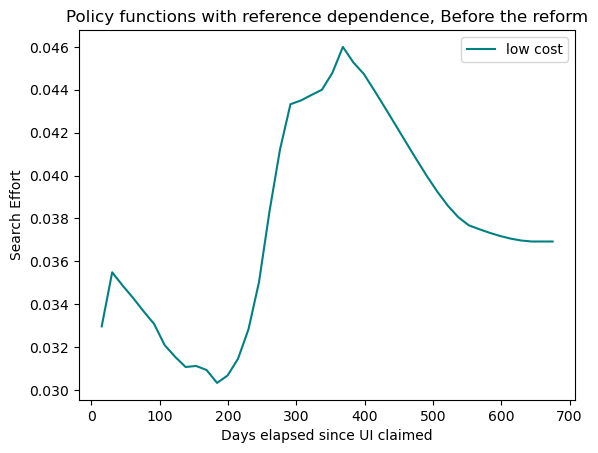

In [3]:
value_function_employment_ConSav(model.par, model.sol)
solve_search_and_consumption_ConSav(model.par, model.sol)
search_effort = model.sol.s
time = np.linspace(0, model.par.T, model.par.T)
plt.plot((time+1)*15, search_effort[0,:,0], label = 'low cost', color='teal') 
# plt.plot((time+1)*15, search_effort[1,:,0], label = 'medium cost', color='orange') 
#plt.plot(time, search_effort[2,:], label = 'high' ) 
#plt.text(0.5, 0.96, '(Note that high cost is 0)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions with reference dependence, Before the reform')
plt.legend()
plt.show()

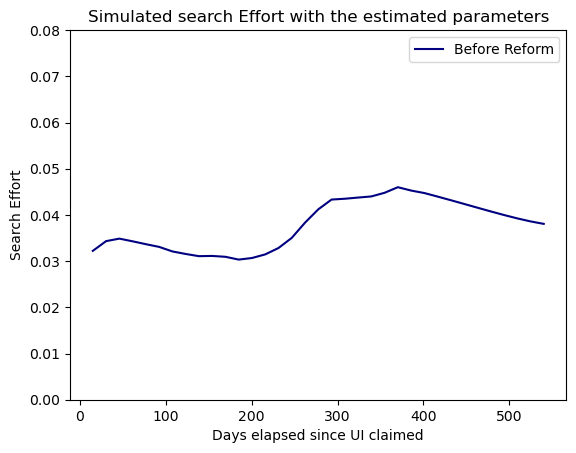

In [4]:
model.solve()
sim = model.sim.s_total
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim[:], color='navy', label='Before Reform') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

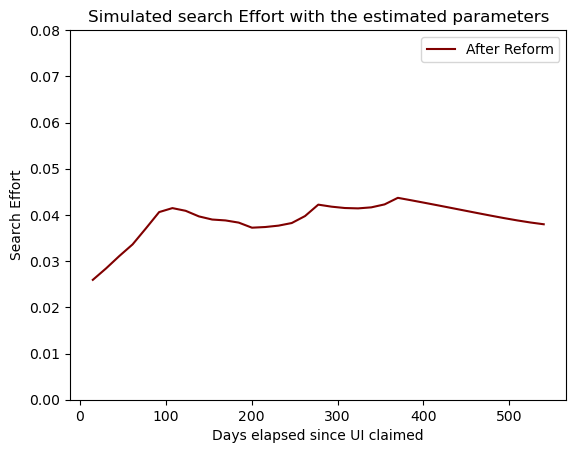

In [5]:
model_after = deepcopy(model)
model_after.par.b1 = 342.0/675.0      # Value after reform
model_after.par.b2 = 171.0/675.0      # Value after reform

model_after.allocate()
model_after.solve()
s_forecast = model_after.sim.s_total

true_data_outofsample = model.data.moments_after
true_data_insample = model.data.moments_before
mse_eta1_outofsample = np.mean((true_data_outofsample - s_forecast)**2)
mse_eta1_insample = np.mean((true_data_insample - sim)**2)

# Now plotting s_forecast
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, s_forecast, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

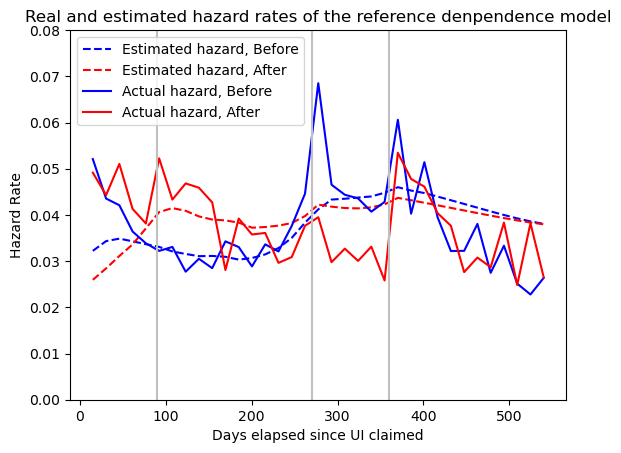

In [6]:
#Replicating figure 7(b) from the paper
after = model_new.data.moments_after
before = model_new.data.moments_before

time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim[:model.par.T_sim], color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the reference denpendence model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# Model with **NO** reference dependence (standard model)

In [7]:


model_new.par.eta = 0.0     # Removes reference dependence
model_new.par.types = 3    # Allow for heterogeneity
# model_new.par.full_sample_estimation = True
model_new.allocate()

est_par = ['delta','gamma', 'cost1', 'cost2', 'cost3', 'type_shares1', 'type_shares3', 'L'] # Parameters to estimate
theta0 = [0.9, 0.9, 84, 242, 310, 0.4, 0, -0.3] # Initial guesses
bounds = [(0.0,1.0), (0, 50.0), (0.0, model_new.par.cost2), (model_new.par.cost1,model_new.par.cost3), (model_new.par.cost2,700.0), (0,1), (0,1-model_new.par.type_shares1), (-0.9,0.0)] # Bounds for the parameters

# est = method_simulated_moments(model_new, est_par,theta0,bounds,weight=False)

model.par.noOfParams = len(est_par)
model.par.noSearchInits = 1
np.random.seed(180615)

for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(model.par.lb_delta, model.par.ub_delta),
              np.random.uniform(model.par.lb_gamma,model.par.ub_gamma),
              np.random.uniform(model.par.lb_lsc,model.par.ub_lsc),
              np.random.uniform(model.par.lb_msc,model.par.ub_msc),
              np.random.uniform(model.par.lb_hsc,model.par.ub_hsc),
              np.random.uniform(model.par.lb_share,model.par.ub_share),
              np.random.uniform(model.par.lb_share,model.par.ub_share),
              np.random.uniform(model.par.lb_L,model.par.ub_L)]

    est_best = np.inf

    try:
        # Perform the method of simulated moments
        est = method_simulated_moments(model, est_par, theta0, bounds, weight=False)

        # Check if the current estimate is better than the best estimate
        if est.fun < est_best:
            est_best = est.fun
            par = est.x
            nit = est.nit

    except Exception as e:
        # Print the exception message and continue with the next iteration
        print(f"Iteration {i} failed with error: {e}")
        continue

print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, est.x):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est.fun:.4f}')
print(f'Number of iterations:    {est.nit}')

d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\solve_consumption_saving.py:328: RuntimeWarning: invalid value encountered in divide
  type_shares = type_shares / sum(type_shares)
c:\Users\rasmu\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\Funcs.py:64: RuntimeWarning: invalid value encountered in scalar power
  inv_c_marg[0] = (s/par.cost1)**(1/par.gamma)
d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\Funcs.py:65: RuntimeWarning: invalid value encountered in scalar power
  inv_c_marg[1] = (s/par.cost2)**(1/par.gamma)
d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\Funcs.py:66: RuntimeWarning: invalid value encountered in scalar powe

Error at t=42, i_a=0
Error message: NaN result encountered.
Current function value: 3.6307325430757054
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: 3.6307325430757054
       x: -0.8524592953892741
     nit: 21
    nfev: 21
Error at t=42, i_a=6
Error message: NaN result encountered.
Current function value: -1.2477861432484907
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: -1.2477861432484907
       x: -0.8524577897714196
     nit: 25
    nfev: 25
Error at t=42, i_a=7
Error message: NaN result encountered.
Current function value: -1.521651044867829
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: -1.521651044867829
       x: -0.852460240871578
     nit: 25
    nfev: 25
Error at t=41, i_a=0
Error message: NaN result encountered.
Current function value: nan
Optimization result details:  message: NaN result encountered.
 success: F

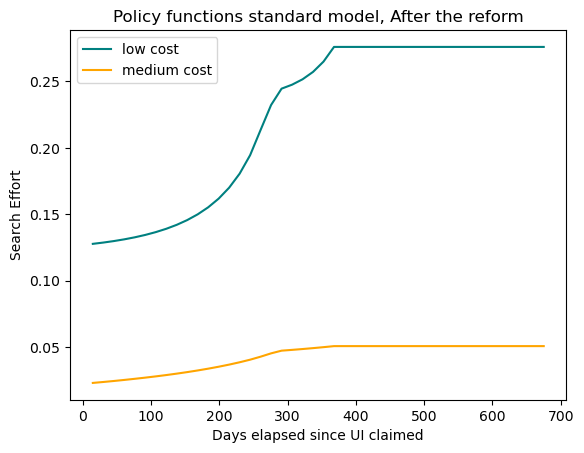

In [8]:
value_function_employment_ConSav(model_new.par, model_new.sol)
solve_search_and_consumption_ConSav(model_new.par, model_new.sol)
search_effort_new = model_new.sol.s

time = np.linspace(0, model_new.par.T, model_new.par.T)
plt.plot((time+1)*15, search_effort_new[0,:,0], label = 'low cost', color='teal') 
plt.plot((time+1)*15, search_effort_new[1,:,0], label = 'medium cost', color='orange') 
# plt.plot((time+1)*15, search_effort_new[2,:], label = 'high', color='brown' ) 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions standard model, After the reform')
plt.legend()
plt.show()

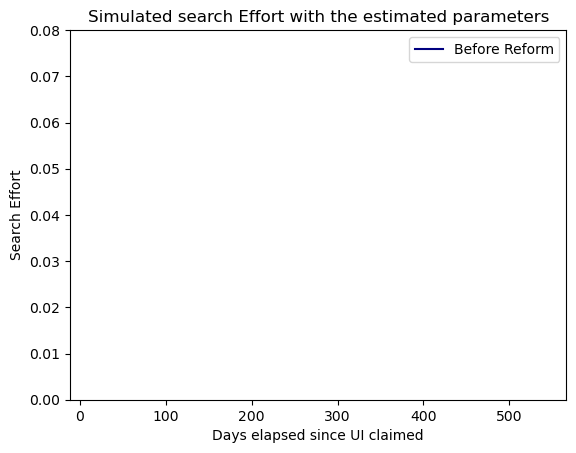

In [9]:
model_new.par.b1 = 222/675*model_new.par.w    # High transfers
model_new.par.b2 = model_new.par.b1    # Medium transfers
model_new.allocate()
model_new.solve()
sim_new = model_new.sim.s_total

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new[:], label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()


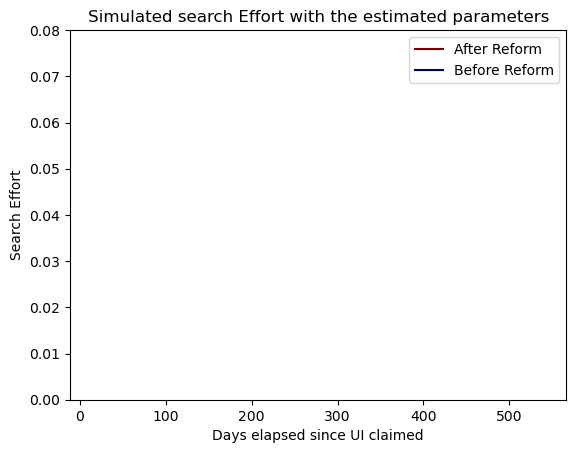

In [10]:
model_new.par.b1 = 342.0/675.0      # Value after reform
model_new.par.b2 = 171.0/675.0      # Value after reform

model_new.allocate()
model_new.solve()
s_forecast_new = model_new.sim.s_total

# Now plotting s_forecast
time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, s_forecast_new, label='After Reform', color='maroon')
plt.plot((time+1)*15, sim_new[:], label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

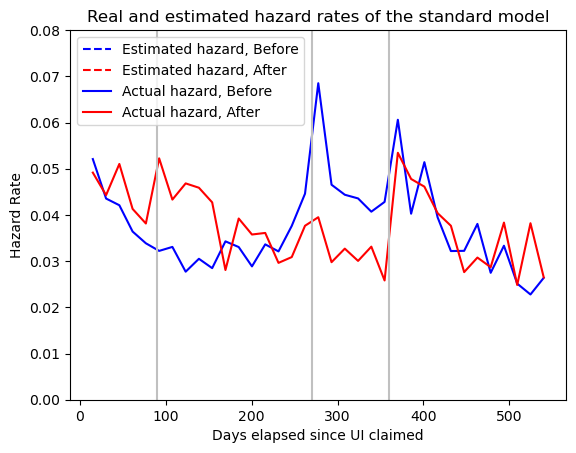

In [11]:
#Replicating figure 7(a) from the paper
after = model_new.data.moments_after
before = model_new.data.moments_before

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast_new, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the standard model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# **Comparison of the standard model and reference dependence**
### Through the Mean Square Error

In [12]:
true_data_outofsample = model_new.data.moments_after
true_data_insample = model_new.data.moments_before

# Get the mean square errors
mse_eta0_outofsample = np.mean((true_data_outofsample - s_forecast_new)**2)
mse_eta0_insample = np.mean((true_data_insample - sim_new)**2)

# Comparison out of sample
comparison1 = "smaller" if mse_eta1_outofsample < mse_eta0_outofsample else "bigger" if mse_eta1_outofsample > mse_eta0_outofsample else "equal"
comparison2 = "WITH reference dependence" if mse_eta1_outofsample < mse_eta0_outofsample else "WITHOUT reference dependence" 

# Comparison in sample
comparison3 = "smaller" if mse_eta1_insample < mse_eta0_insample else "bigger" if mse_eta1_insample > mse_eta0_insample else "equal"
comparison4 = "WITH reference dependence" if mse_eta1_insample < mse_eta0_insample else "WITHOUT reference dependence"


print("Before the reform: ")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_insample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_insample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison3}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison4}\033[0m.")
print("-" * 100)



print("After the reform:")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_outofsample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_outofsample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison1}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison2}\033[0m.")
print("-" * 100)

Before the reform: 
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 0.00012305312030258867
The mean square error from the model without reference dependence is 0.03357953371621259
The mean square error for the model with reference dependence is smaller than the model without.
Best model: WITH reference dependence.
----------------------------------------------------------------------------------------------------
After the reform:
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 8.090644432353418e-05
The mean square error from the model without reference dependence is 0.03552712794487817
The mean square error for the model with reference dependence is smaller than the model without.
Best model: WITH reference dependence.
--------------------------------

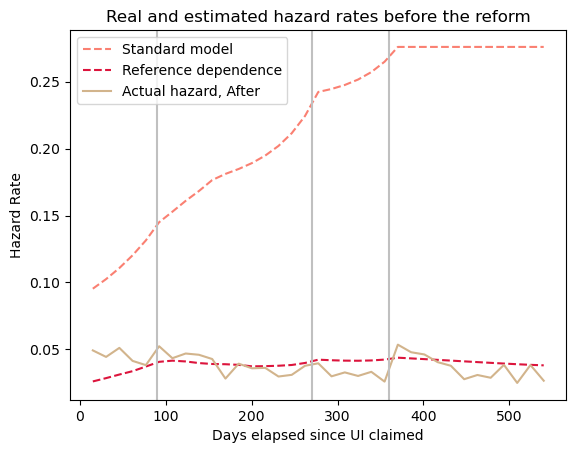

In [13]:
after = model_new.data.moments_after

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, s_forecast_new, label='Standard model', color='salmon', linestyle='--')                     # Model with no reference dependence
plt.plot((time+1)*15, s_forecast, label='Reference dependence', color='crimson', linestyle='--')                         # Model with reference dependence
plt.plot((time+1)*15, after, label='Actual hazard, After', color='tan')                        # True data
# Make a vertical line at 90, 270 and 360
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()

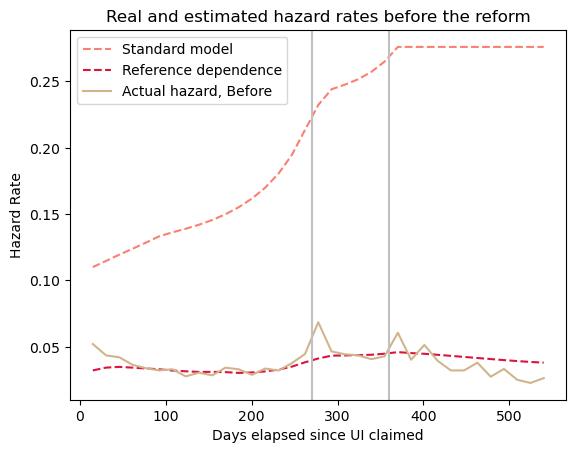

In [14]:
before = model_new.data.moments_before

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, sim_new, label='Standard model', color='salmon', linestyle='--')                            # Model with no reference dependence
plt.plot((time+1)*15, sim, label='Reference dependence', color='crimson', linestyle='--')                                # Model with reference dependence
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='tan')                           # True data
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()